# Power Spectrum Multipole Covariance

## Setup

In [1]:
import warnings
import numpy as np
from scipy.interpolate import CubicSpline, interp1d, UnivariateSpline
from scipy.special import legendre
from sympy.physics.wigner import wigner_3j
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
plt.rcParams['text.usetex'] = False
from mcfit import P2xi, xi2P
from avgem import avg
np.set_printoptions(linewidth=100)

In [2]:
z_bin = 3

# We want matching s for different l, but lowring=False with an even N is
# problematic, because the forward and backward transformation matrix are no
# longer inverse of each other -- their product is the identity matrix with
# some huge corner oscillations
# Therefore, I use Odd N (powers of 3) here
lowring=False
lgkmin, lgkmax = -6, 2
Nk = 3645

k = np.logspace(lgkmin, lgkmax, num=Nk, endpoint=False)
T1 = P2xi(k, N=len(k), lowring=lowring)
s = T1.y # NOTE: when lowring=True, this `s` is only appropriate for l=0
T2 = xi2P(s, N=len(s), lowring=lowring)
assert np.allclose(T2.y, k, rtol=1e-10, atol=0)

def get_s(k, lowring=False):
    return P2xi(k, N=len(k), lowring=lowring).y

def get_ell(l_max):
    return np.arange(0, l_max+1, 2)

def get_const(z_bin):
    const = {}
    
    const['alpha_Q'] = 0.2
    const['alpha_P'] = 0.02
    
    if z_bin == 1:
        const['S0'] = 1.296222442253179615e+05
        const['W0'] = 4.012851294209899322e+01
        
        const['SS0'] = 2.412316246590063606e+00
        const['WS0'] = 7.304557958097776397e-04
        const['WW0'] = 2.310708077931338384e-07
    elif z_bin == 2:
        const['S0'] = 1.487164956197324500e+05
        const['W0'] = 4.732807813897710503e+01
        
        const['SS0'] = 2.735050863650106301e+00
        const['WS0'] = 8.468798124494847845e-04
        const['WW0'] = 2.765543102633729196e-07
    elif z_bin == 3:
        const['S0'] = 2.825013572057803976e+05
        const['W0'] = 4.542545521052436186e+01
        
        const['SS0'] = 5.849509325047407060e+00
        const['WS0'] = 8.995672356970692719e-04
        const['WW0'] = 2.158460117153556665e-07
    else:
        raise NotImplementedError
    
    const['S0'] *= const['alpha_Q'] * (1 + const['alpha_P'])
    const['W0'] *= const['alpha_Q']
    
    const['SS0'] *= const['alpha_Q'] * (1 + const['alpha_P'])**2
    const['WS0'] *= const['alpha_Q'] * (1 + const['alpha_P'])
    const['WW0'] *= const['alpha_Q']
    
    const['Veff'] = const['W0']**2 / const['WW0']
    const['Pshot'] = const['S0'] / const['W0']
    
    return const

def rescale_kk(k, power):
    return k[:, None]**power * k**power

In [3]:
def deflate(M):
    if M.ndim == 4 and M.shape[0] == M.shape[1] == M.shape[2] == M.shape[3]:
        warnings.warn("Ambiguity in deflation")
    
    if M.ndim == 2 and M.shape[0] == M.shape[1]:
        return M
    if M.ndim == 4 and M.shape[0] == M.shape[1] and M.shape[2] == M.shape[3]:
        return M.swapaxes(1, 2).reshape(M.shape[0] * M.shape[2], -1)
    if M.ndim == 4 and M.shape[0] == M.shape[2] and M.shape[1] == M.shape[3]:
        return M.reshape(M.shape[0] * M.shape[1], -1)
    
    raise ValueError

def inflate(M, shape):
    if M.ndim != 2 or M.shape[0] != M.shape[1]:
        raise ValueError
        
    if len(shape) == 4 and shape[0] == shape[1] == shape[2] == shape[3]:
        warnings.warn("Ambiguity in inflation")
    
    if M.shape == shape:
        return M
    if len(shape) == 4 and shape[0] == shape[1] and shape[2] == shape[3]:
        shape = (shape[0], shape[2], shape[1], shape[3])
        return M.reshape(shape).swapaxes(1, 2)
    if len(shape) == 4 and shape[0] == shape[2] and shape[1] == shape[3]:
        return M.reshape(shape)
    
    raise ValueError

def lowrank(M, rank):
    """Return the low-rank part of a matrix."""
    w, v = np.linalg.eigh(deflate(M))
    if rank < 0 or rank >= len(w):
        raise ValueError
    
    idx = np.argsort(np.abs(w))[len(w)-rank:]
    
    Mlow = np.zeros_like(v)
    Mlow += sum(w[i] * v[:, [i]] * v[:, i] for i in idx)
    
    Mlow = inflate(Mlow, M.shape)
    return Mlow

def smooth_eig(M, rank, rank0=0):
    w, v = np.linalg.eigh(deflate(M))
    
    idx = np.argsort(np.abs(w))[len(w)-rank:len(w)-rank0]
    idx = idx[::-1]
    
    v_smooth = np.zeros((v.shape[0], rank))
    if M.ndim == 2:
        x = np.arange(len(w))
        for ith, i  in enumerate(idx):
            v_smooth[:, ith] = UnivariateSpline(x, v[:, i])(x)
    elif M.ndim == 4:
        x = np.arange(M.shape[-1])
        for ith, i in enumerate(idx):
            for j in range(M.shape[0]):
                v_smooth[j*len(x):(j+1)*len(x), ith] = \
                    UnivariateSpline(x, v[j*len(x):(j+1)*len(x), i])(x)
    else:
        raise ValueError
    
    return w[idx], v[:, idx], v_smooth

def plteig(M, rank, rank0=0):
    w, v, v_smooth = smooth_eig(M, rank, rank0=rank0)
    
    plt.axhline(0, c='k')
    alphas = np.linspace(1, 0.5, rank)
    ith = rank0
    for val, vec, vec_smooth, alpha in zip(w, v.T, v_smooth.T, alphas):
        ith += 1
        l, = plt.plot(vec, label=f"$\lambda_{{{ith}}}={val:.2g}$", alpha=alpha)
        plt.plot(vec_smooth, c=l.get_color(), alpha=alpha)
    plt.legend()
    
    plt.show()

def pltmat(M, scale='symlog', vlim=None, linthresh=None, linscale=1, sav=None):
    """Visualize a matrix.
    
    Parameters
    ----------
    M : 2d or 4d ndarray, or array_like of 2d ndarray
    """
    width = height = 4
    
    M = np.asarray(M)
    if M.ndim == 2 and M.shape[0] == M.shape[1]:
        Ms = [M]
    elif M.ndim == 3 and M.shape[1] == M.shape[2]:
        Ms = M
        width *= M.shape[0]
    elif M.ndim == 4:
        Ms = [deflate(M)]
        width *= M.shape[1]
        height *= M.shape[0]
    else:
        raise ValueError
    
    num = len(Ms)
    _, axes = plt.subplots(ncols=num, squeeze=False, figsize=(width, height))
    axes = axes.ravel()
    
    if Ms[0].shape[0] > 1000:
        method = "matshow"
    else:
        method = "pcolormesh"
    
    if vlim is None:
        vlim = np.abs(Ms).max()
        
    if scale == 'linear':
        for i, M in enumerate(Ms):
            plot = getattr(axes[i], method)
            im = plot(M, vmin=-vlim, vmax=vlim, cmap='RdBu_r')
            axes[i].set_aspect('equal', adjustable='box')
    elif scale == 'symlog':
        if linthresh is None:
            linthresh = 1e-4 * vlim
        for i, M in enumerate(Ms):
            plot = getattr(axes[i], method)
            im = plot(M, norm=SymLogNorm(linthresh=linthresh, linscale=linscale,
                                         vmin=-vlim, vmax=vlim), cmap='RdBu_r')
            axes[i].set_aspect('equal', adjustable='box')
    else:
        raise ValueError
        
    plt.colorbar(im, ax=axes)
    
    if sav:
        plt.savefig(sav)
        
def cov2cor(cov, cov_norm=None):
    """Normalize a matrix by the diagonal."""
    if cov_norm is None:
        cov_norm = cov
    
    cor = deflate(cov_norm).diagonal()
    cor = np.sqrt(cor[:, None] * cor)
    cor = deflate(cov) / cor
    
    cor = inflate(cor, cov.shape)
    return cor

def cor2cov(cor, cov_norm):
    """Rescale a correlation matrix using the diagonal of a covariance matrix."""
    cov_norm = deflate(cov_norm).diagonal()
    cov_norm = np.sqrt(cov_norm[:, None] * cov_norm)
    cov = deflate(cor) * cov_norm
    
    cov = inflate(cov, cor.shape)
    return cov

## Hankel transforms, window multipoles, window matrix

In [4]:
def get_H(k, l_max=8, lowring=False):
    """Return Hankel circulant matrix for all (l, k, k')"""
    ell = get_ell(l_max)
    return np.stack([P2xi(k, l=l, N=len(k), lowring=lowring).matrix(full=False)[2] for l in ell], axis=0)
# xi2P should give the same result with matrix(full=False)

In [5]:
%%time

H = get_H(k)

CPU times: user 383 ms, sys: 771 ms, total: 1.15 s
Wall time: 1.16 s


/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


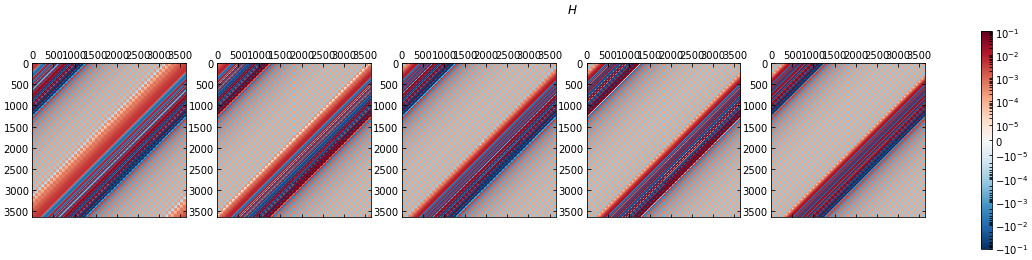

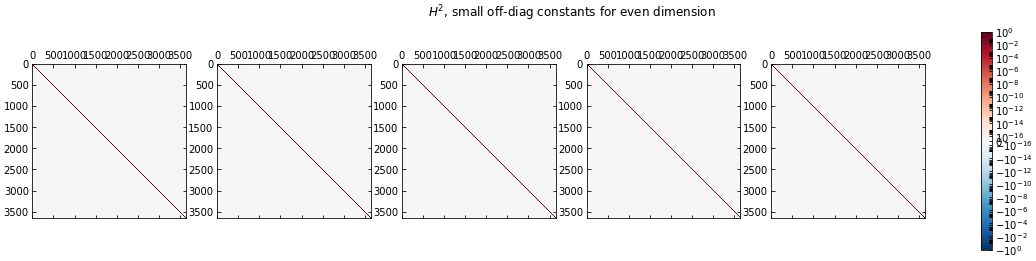

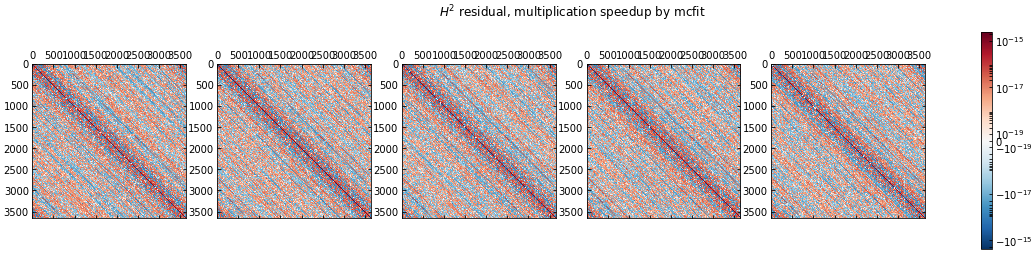

In [7]:
pltmat(H)
plt.suptitle("$H$")
pltmat([Hi @ Hi for Hi in H], linthresh=1e-16)
plt.suptitle("$H^2$, small off-diag constants for even dimension");
pltmat([P2xi(k, l=2*i, N=len(k), lowring=lowring)(H[i], axis=1, convonly=True)[1]
       - H[i] @ H[i] for i in range(len(H))])
plt.suptitle("$H^2$ residual, multiplication speedup by mcfit");

In [6]:
def get_Qls(s, w_type, z_bin, simple=False, l_max=16):
    """Return Q_l(s) for all (l, s)
    
    If `simple == True`, return a simple monopole,
    in this simple case, l_max controls the number of higher order multipoles
    """
    if simple:
        ell = get_ell(l_max)
        Q = np.zeros(ell.shape + s.shape)
        
        if w_type == 'nw2_nw2':
            Q[0] = get_const(z_bin)['WW0']
        elif w_type == 'nw2_w2':
            Q[0] = get_const(z_bin)['WS0']
        elif w_type == 'w2_w2':
            Q[0] = get_const(z_bin)['SS0']
        else:
            raise ValueError
        
        return Q
    
    Ql_file = f"patchy/Ql_model_z{z_bin}_{w_type}.dat"
    Ql_data = np.loadtxt(Ql_file, unpack=True)
    _s = Ql_data[0]
    _Q = Ql_data[1:]
    
    _Q *= get_const(z_bin)['alpha_Q']**2
    
    if w_type == 'nw2_w2':
        _Q *= 1 + get_const(z_bin)['alpha_P']
    elif w_type == 'w2_w2':
        _Q *= (1 + get_const(z_bin)['alpha_P'])**2

    Q = interp1d(_s, _Q, bounds_error=False, fill_value=0)(s)
#     Q = CubicSpline(_s, _Q, axis=1)(s)
#     Q[:, s<_s.min()] = 0
#     Q[:, s>_s.max()] = 0
    
    return Q

def get_Qlls(s, l_max, lp_max, l_Q_max, w_type, z_bin, simple):
    """Return Q_ll(s) for all (l, l', s)"""
    Qls = get_Qls(s, w_type, z_bin, simple=simple, l_max=l_Q_max)
    
    ell = get_ell(l_max)
    ell_prime = get_ell(lp_max)
    
    Q = np.zeros((len(ell), len(ell_prime), len(s)))
    
    for i, l in enumerate(ell):
        for j, lp in enumerate(ell_prime):
            for l_Q in range(abs(l-lp), min(l+lp, l_Q_max) + 1, 2):
                w3sq = wigner_3j(l, lp, l_Q, 0, 0, 0)**2
                Q[i, j] += float(w3sq) * Qls[l_Q//2]
            Q[i, j] *= (-1)**(i+j)
            
    return Q

def get_Qllkk(k, l_max, lp_max, l_Q_max, w_type, z_bin, simple):
    """Return Q_ll(k, k) for all (l, l', k, k')"""
    s = get_s(k)
    
    ell = get_ell(l_max)
    ell_prime = get_ell(lp_max)
    
    Qlls = get_Qlls(s, l_max, lp_max, l_Q_max, w_type, z_bin, simple)
    
    Q = H[:len(ell), None, ...] * Qlls[..., None, :]
    
    for j, lp in enumerate(ell_prime):
        for i, l in enumerate(ell):
            #Q[i, j] = Q[i, j] @ H[j]
            _, Q[i, j] = P2xi(k, l=lp, N=len(k),
                              lowring=lowring)(Q[i, j], axis=1,
                                               extrap=False, convonly=True)

    dlnk = np.diff(np.log(k)).mean()
    Q *= 2 * np.pi**2 / dlnk / rescale_kk(k, 1.5)
    
    return Q

In [7]:
def get_Plk(k, z_bin, add_shot, convolved=False):
    """Return P_l(k) for all (l, k)"""
    Pl_file = f"patchy/Pl_model_z{z_bin}.dat"
    if convolved:
        Pl_file = f"patchy/Pl_model_z{z_bin}_conv.dat"
    Pl_data = np.loadtxt(Pl_file, unpack=True)
    _k = Pl_data[0]
    _P = Pl_data[1:]
    
    # interpolate
    P = CubicSpline(_k, _P, axis=1)(k)
    # extrapolate as pow-law on the low-k side
    k_left = k[k < _k.min()]
    lnP_left = interp1d(np.log(_k[:2]), np.log(_P[:, :2]), axis=1, kind='linear',
                        fill_value='extrapolate', assume_sorted=True)(np.log(k_left))
    P[:, k < _k.min()] = np.exp(lnP_left)
    # zero at the high-k end
#     P[:, k < _k.min()] = 0
    P[:, k > _k.max()] = 0
    
    if add_shot:
        P[0] += get_const(z_bin)['Pshot']
    
    return P

def get_Pllk(k, l_max, lp_max, l_P_max, z_bin, add_shot=False):
    """Return P_ll(k) for all (l, l', k)"""
    Plk = get_Plk(k, z_bin, add_shot)
    
    ell = get_ell(l_max)
    ell_prime = get_ell(lp_max)
    
    P = np.zeros((len(ell), len(ell_prime), len(k)))
    
    for i, l in enumerate(ell):
        for j, lp in enumerate(ell_prime):
            for l_P in range(abs(l-lp), min(l+lp, l_P_max) + 1, 2):
                w3sq = wigner_3j(l, l_P, lp, 0, 0, 0)**2
                P[i, j] += float(w3sq) * Plk[l_P//2]
            P[i, j] *= (2*lp+1)
            
    return P

/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


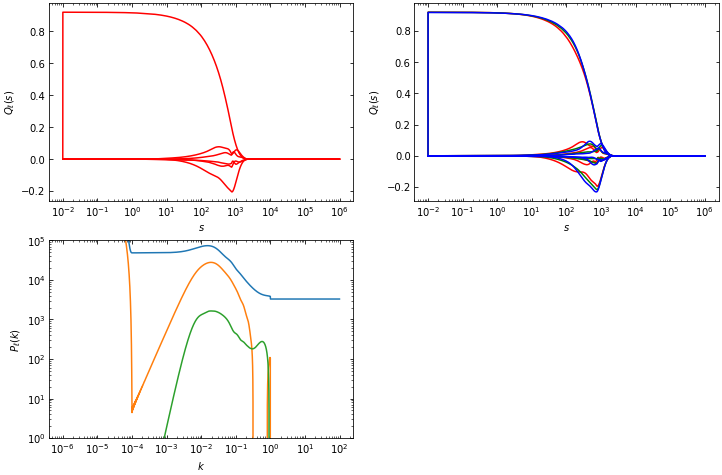

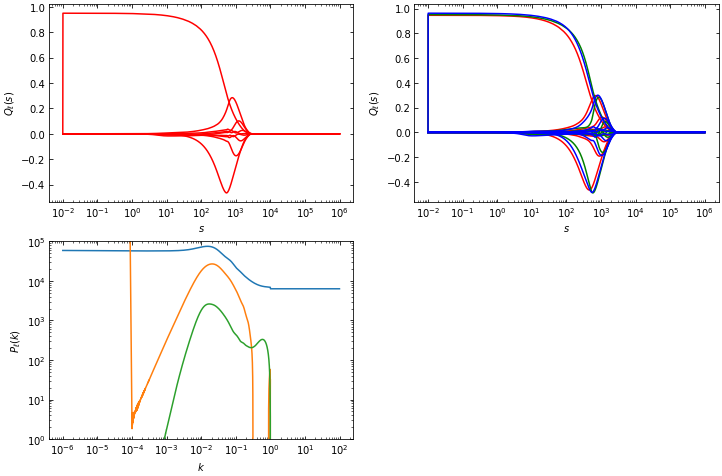

In [91]:
def plt_PQ(z_bin):
    s = get_s(k)
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(221)
    plt.plot(s, get_Qls(s, 'w_w', z_bin).T / get_const(z_bin)['W0'], 'r-')
    plt.xscale('log')
    plt.xlabel('$s$')
    plt.ylabel('$Q_\ell(s)$')
    
    plt.subplot(222)
    plt.plot(s, get_Qls(s, 'nw2_nw2', z_bin).T / get_const(z_bin)['WW0'], 'r-')
    plt.plot(s, get_Qls(s, 'nw2_w2', z_bin).T / get_const(z_bin)['WS0'], 'g-')
    plt.plot(s, get_Qls(s, 'w2_w2', z_bin).T / get_const(z_bin)['SS0'], 'b-')
    plt.xscale('log')
    plt.xlabel('$s$')
    plt.ylabel('$Q_\ell(s)$')
    
    plt.subplot(223)
    plt.plot(k, get_Plk(k, z_bin, add_shot=True, convolved=True).T, ls='-')
    plt.ylim(1, 1e5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$k$')
    plt.ylabel('$P_\ell(k)$')
    
    plt.show()

plt_PQ(1)
# plt_PQ(2)
plt_PQ(3)

# below saves the raw data (without fitting)
# np.savez("fig/Ql.npz", s=get_s(k),
#          QW = get_Qls(s, 'nw2_nw2', z_bin) / get_const(z_bin)['WW0'],
#          QX = get_Qls(s, 'nw2_w2', z_bin) / get_const(z_bin)['WS0'],
#          QS = get_Qls(s, 'w2_w2', z_bin) / get_const(z_bin)['SS0'])

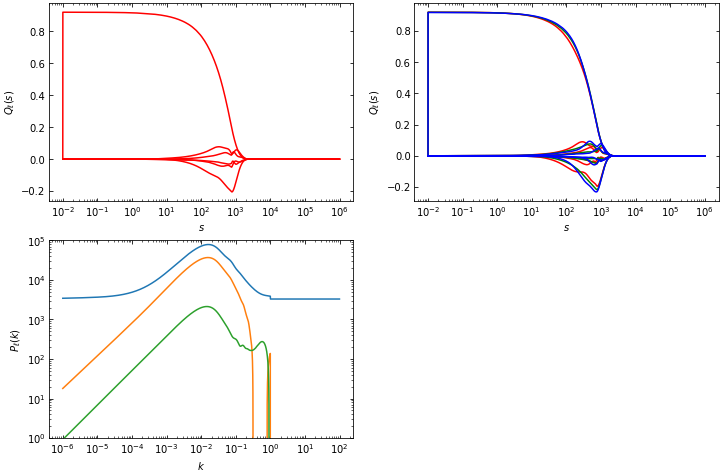

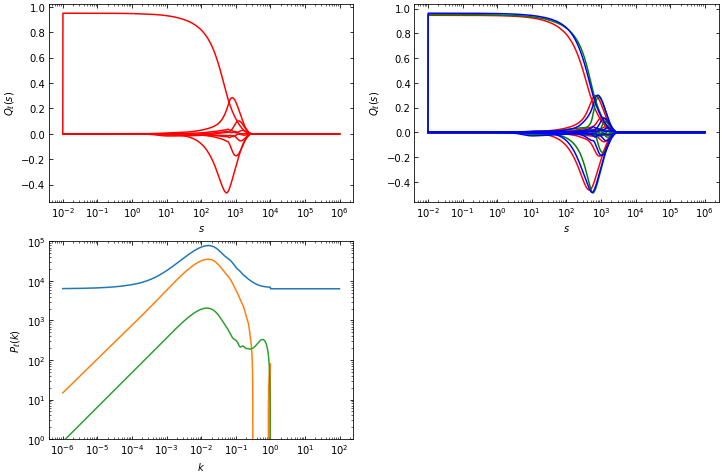

In [48]:
def plt_PQ(z_bin):
    s = get_s(k)
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(221)
    plt.plot(s, get_Qls(s, 'w_w', z_bin).T / get_const(z_bin)['W0'], 'r-')
    plt.xscale('log')
    plt.xlabel('$s$')
    plt.ylabel('$Q_\ell(s)$')
    
    plt.subplot(222)
    plt.plot(s, get_Qls(s, 'nw2_nw2', z_bin).T / get_const(z_bin)['WW0'], 'r-')
    plt.plot(s, get_Qls(s, 'nw2_w2', z_bin).T / get_const(z_bin)['WS0'], 'g-')
    plt.plot(s, get_Qls(s, 'w2_w2', z_bin).T / get_const(z_bin)['SS0'], 'b-')
    plt.xscale('log')
    plt.xlabel('$s$')
    plt.ylabel('$Q_\ell(s)$')
    
    plt.subplot(223)
    plt.plot(k, get_Plk(k, z_bin, add_shot=True).T, ls='-')
    plt.ylim(1, 1e5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$k$')
    plt.ylabel('$P_\ell(k)$')
    
    plt.show()

plt_PQ(1)
# plt_PQ(2)
plt_PQ(3)

# below saves the raw data (without fitting)
# np.savez("fig/Ql.npz", s=get_s(k),
#          QW = get_Qls(s, 'nw2_nw2', z_bin) / get_const(z_bin)['WW0'],
#          QX = get_Qls(s, 'nw2_w2', z_bin) / get_const(z_bin)['WS0'],
#          QS = get_Qls(s, 'w2_w2', z_bin) / get_const(z_bin)['SS0'])

In [49]:
def l2mu(L, Nmu, avg=True):
    l_max = 2 * L.shape[0] - 2
    ell = range(0, l_max+1)
    
    mu_edge = np.linspace(0, 1, num=Nmu+1, endpoint=True)
    mu_cent = 0.5 * (mu_edge[1:] + mu_edge[:-1])
    dmu = 1 / Nmu
    
    M = np.zeros((Nmu, L.shape[1]))
    
    for i, l in enumerate(ell):
        if avg:
            leg = np.diff(legendre(l).integ()(mu_edge)) / dmu
        else:
            leg = legendre(l)(mu_cent)
        M += L[i] * leg[:, None]
    
    return M

def mu2l(M, l_max):
    Nmu = M.shape[0]
#     mu_edge = np.linspace(-1, 1, num=Nmu+1, endpoint=True)
    mu_edge = np.linspace(0, 1, num=Nmu+1, endpoint=True)
    mu_cent = 0.5 * (mu_edge[1:] + mu_edge[:-1])
    dmu = 1 / Nmu
    
    ell = range(0, l_max+1, 2)
    
    L = np.zeros((len(ell), M.shape[1]))
    
    for i, l in enumerate(ell):
        L[i] = legendre(l)(mu_cent) @ M * (2*l+1) * dmu / 2
    
    return L

def inv_pole(L, l_inv_max):
    """Inverse multipole moments.

    Solve A b = (1, 0, 0, ...)
    """
    l_max = 2 * L.shape[0] - 2
    ell = range(0, l_max+1, 2)

    ell_inv = range(0, l_inv_max+1, 2)
    A = np.zeros((L.shape[1], len(ell_inv), len(ell_inv)))

    for i, li in enumerate(ell_inv):
        for j, lj in enumerate(ell_inv):  # (2*lj+1) can be dropped
            for l in range(abs(li-lj), min(li+lj, l_max) + 1, 2):
                w3sq = wigner_3j(l, li, lj, 0, 0, 0)**2
                A[:, i, j] += L[l//2] * float(w3sq)

    mono = np.zeros((1, len(ell_inv)))
    mono[0, 0] = 1

    L_inv = np.linalg.solve(A, mono)
    L_inv = L_inv.T

    return L_inv

In [8]:
def get_Cllkk(k, z_bin, l_max=4, l_P_max=4, l_Q_max=16, simple_shot=False, simple_window=False):
    """Return C_ll(k, k) for all (l, l', k, k')"""
    P = get_Pllk(k, l_max, l_max+l_P_max, l_P_max, z_bin, add_shot=simple_shot)
    
    QW = get_Qllkk(k, l_max+l_P_max, l_max+l_P_max, l_Q_max, 'nw2_nw2', z_bin, simple_window)
    
    ell = get_ell(l_max)
    
    C = np.zeros((len(ell), len(ell), len(k), len(k)))
    
    for i in range(QW.shape[0]):
        for j in range(QW.shape[1]):
            C += P[:, i][:, None, :, None] * QW[[i], [j]] * P[:, j][None, :, None, :]
    
    if not simple_shot:
        QX = get_Qllkk(k, l_max+l_P_max, l_max, l_Q_max, 'nw2_w2', z_bin, simple_window)
        QS = get_Qllkk(k, l_max, l_max, l_Q_max, 'w2_w2', z_bin, simple_window)
        
        CX = np.zeros_like(C)
        
        for i in range(QX.shape[0]):
            CX += P[:, i][:, None, :, None] * QX[[i]]
        CX += CX.swapaxes(0, 1).swapaxes(2, 3)
        
        CS = QS
        
        C += CX + CS
    
    C *= 2 * (2*ell+1)[:, None, None, None] * (2*ell+1)[None, :, None, None] \
        / get_const(z_bin)['W0']**2
    
    return C

In [9]:
P0 = get_Plk(k, z_bin, add_shot=False)[0]
#np.savez("fig/shot_window.npz", k=k, C0=C0, C1=C1, P0=P0)
#np.load("fig/shot_window.npz").keys()
#C0 = np.load("fig/shot_window.npz")["C0"]
#C1 = np.load("fig/shot_window.npz")["C1"]

In [52]:
%%time

# C1 = get_Cllkk(k, z_bin, simple_shot=True)
# C1 = get_Cllkk(k, z_bin, simple_window=True)
# C1 = get_Cllkk(k, z_bin, simple_shot=True, simple_window=True)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [10]:
%%time

C0 = get_Cllkk(k, z_bin, l_Q_max=16)
# C0 = get_Cllkk(k, z_bin, l_Q_max=10)

CPU times: user 46.8 s, sys: 43.8 s, total: 1min 30s
Wall time: 1min 30s


/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


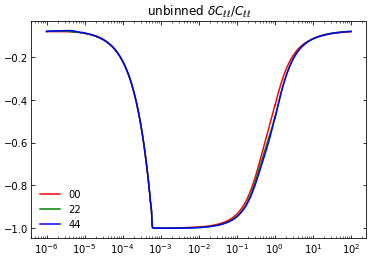

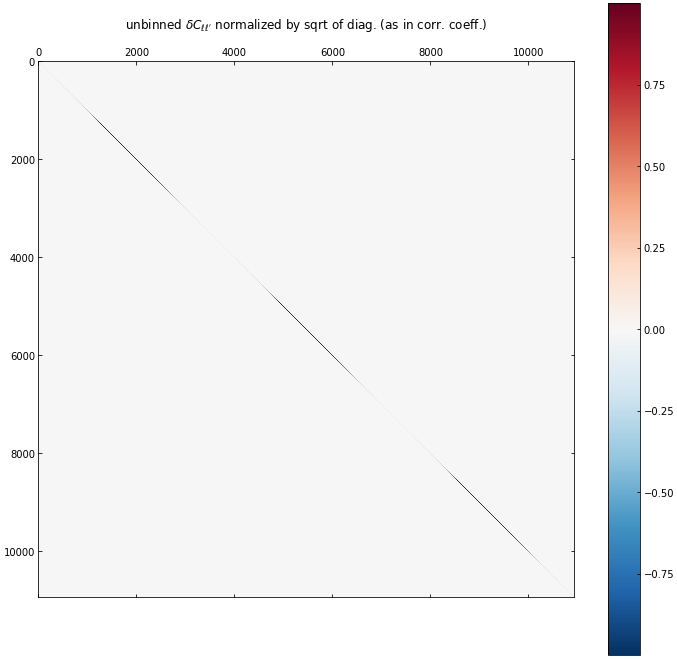

In [37]:
plt.plot(k, C0[0, 0].diagonal() / C1[0, 0].diagonal() - 1, 'r-', label='00')
plt.plot(k, C0[1, 1].diagonal() / C1[1, 1].diagonal() - 1, 'g-', label='22')
plt.plot(k, C0[2, 2].diagonal() / C1[2, 2].diagonal() - 1, 'b-', label='44')
plt.xscale('log')
plt.legend()
plt.title("unbinned $\delta C_{\ell\ell} / C_{\ell\ell}$")
plt.show()

r_diff = cov2cor((C0 - C1), C1)
pltmat(r_diff, scale='linear')
plt.title("unbinned $\delta C_{\ell\ell'}$ normalized by sqrt of diag. (as in corr. coeff.)")
plt.show()

In [13]:
%%time

QW = get_Qllkk(k, 8, 8, 16, 'nw2_nw2', z_bin) * rescale_kk(k, 1.5)
QX = get_Qllkk(k, 8, 4, 12, 'nw2_w2', z_bin) * rescale_kk(k, 1.5)
QS = get_Qllkk(k, 4, 4, 8, 'w2_w2', z_bin) * rescale_kk(k, 1.5)

QW_corr = cov2cor(QW)

CPU times: user 28.7 s, sys: 16.1 s, total: 44.9 s
Wall time: 44.9 s


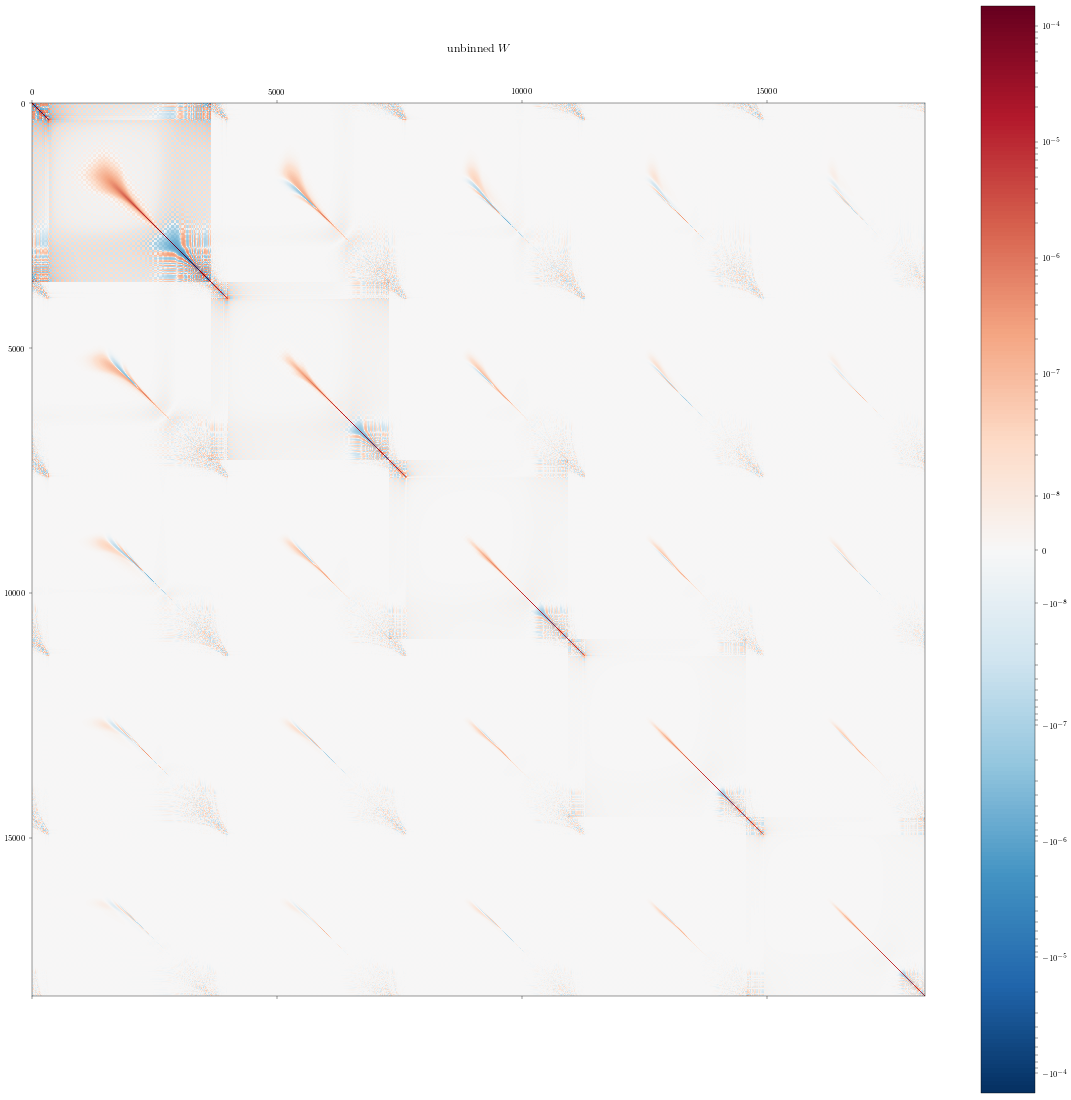

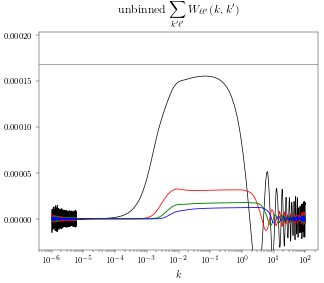

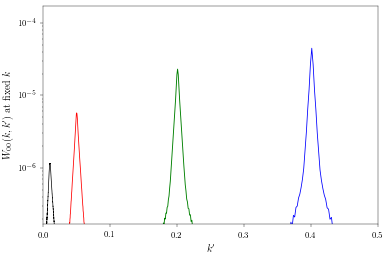

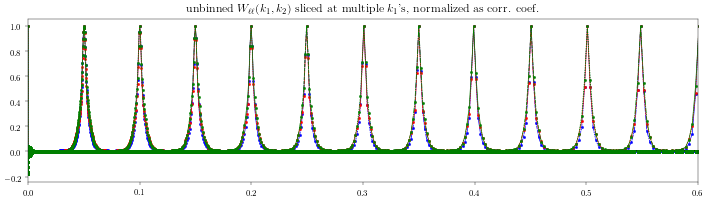

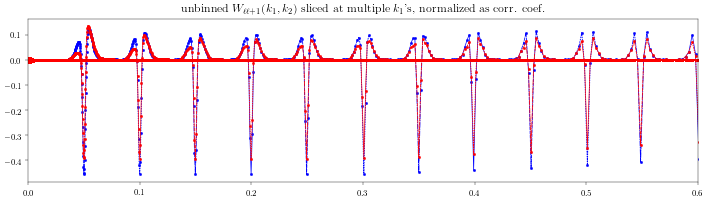

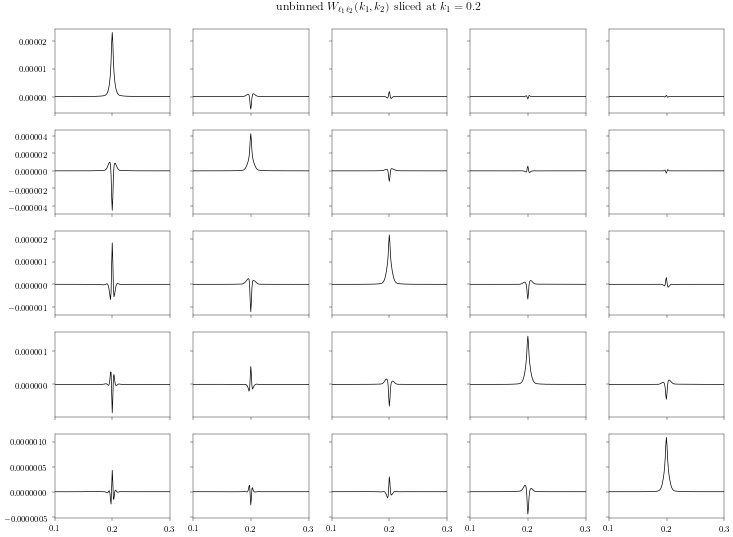

In [39]:
# look at unbinned Q

pltmat(QW)
plt.title("unbinned $W$")

plt.figure(figsize=(5, 4))
plt.plot(k, QW[0].sum(axis=(0, 2)), 'k-')
plt.plot(k, QW[1].sum(axis=(0, 2)), 'r-')
plt.plot(k, QW[2].sum(axis=(0, 2)), 'g-')
plt.plot(k, QW[3].sum(axis=(0, 2)), 'b-')
expect = 2 * np.pi**2 / np.diff(np.log(k)).mean() * get_const(z_bin)['WW0']
plt.axhline(expect, c='.5')
plt.xscale('log')
plt.ylim(-.2*expect, 1.2*expect)
plt.xlabel("$k$")
plt.title("unbinned $\displaystyle \sum_{k' \ell'} W_{\ell\ell'}(k, k')$")
plt.show()

plt.plot(k, QW[0, 0, (k<0.01).sum()], 'k-')
plt.plot(k, QW[0, 0, (k<0.05).sum()], 'r-')
plt.plot(k, QW[0, 0, (k<0.2).sum()], 'g-')
plt.plot(k, QW[0, 0, (k<0.4).sum()], 'b-')
plt.yscale('log')
plt.xlim(0, 0.5)
plt.ylim(0.001*expect, expect)
plt.xlabel("$k'$")
plt.ylabel("$W_{00}(k, k')$ at fixed $k$")
plt.show()

idx = abs(k - np.arange(0.05, 0.6, 0.05)[:, None]).argmin(axis=1)

plt.figure(figsize=(12, 3))
plt.plot(k, QW_corr[0, 0, idx].T, marker='.', c='b')
plt.plot(k, QW_corr[1, 1, idx].T, marker='.', c='r')
plt.plot(k, QW_corr[2, 2, idx].T, marker='.', c='g')
plt.xlim(0, 0.6)
plt.title("unbinned $W_{\ell\ell}(k_1, k_2)$ sliced at multiple $k_1$'s, normalized as corr. coef.")
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(k, QW_corr[0, 1, idx].T, marker='.', c='b')
plt.plot(k, QW_corr[1, 2, idx].T, marker='.', c='r')
plt.xlim(0, 0.6)
plt.title("unbinned $W_{\ell\ell+1}(k_1, k_2)$ sliced at multiple $k_1$'s, normalized as corr. coef.")
plt.show()

kmd = 0.2
idx = abs(k - kmd).argmin()
klo, khi = kmd-0.1, kmd+0.1
_, axes = plt.subplots(QW.shape[0], QW.shape[1], sharex=True, sharey='row', figsize=(12, 9))
for i in range(QW.shape[0]):
    for j in range(QW.shape[1]):
        axes[i, j].plot(k, QW[i, j, idx], 'k')
plt.xlim(klo, khi)
plt.suptitle("unbinned $W_{{\ell_1\ell_2}}(k_1, k_2)$ sliced at $k_1={}$".format(kmd), y=0.92)
plt.show()

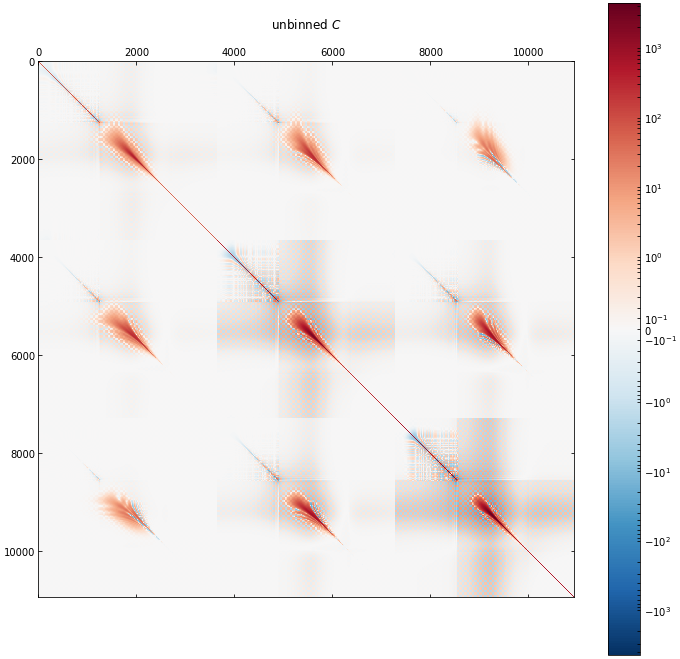

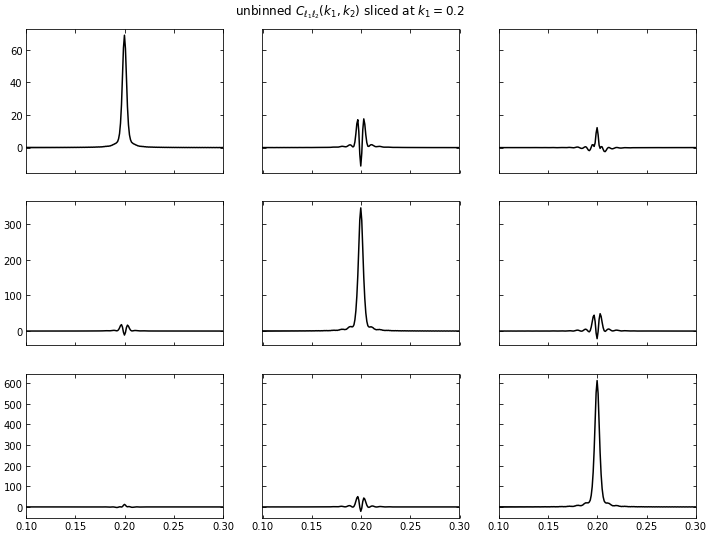

In [41]:
# look at unbinned C

C0_ = C0 * rescale_kk(k, 1.5)

pltmat(C0_)
plt.title("unbinned $C$")
plt.show()

kmd = 0.2
idx = abs(k - kmd).argmin()
klo, khi = k[idx] - 0.1, k[idx] + 0.1

_, axes = plt.subplots(C0_.shape[0], C0_.shape[1], sharex=True, sharey='row', figsize=(12, 9))
for i in range(C0_.shape[0]):
    for j in range(C0_.shape[1]):
        axes[i, j].plot(k, C0_[i, j, idx], 'k')
plt.xlim(klo, khi)
plt.suptitle("unbinned $C_{{\ell_1\ell_2}}(k_1, k_2)$ sliced at $k_1={}$".format(kmd), y=0.92)
plt.show()

## re-bin for band power

In [11]:
kmin, kmax = 0., 0.44
# kmin, kmax = 0., 0.615

dk_bin = 0.005

bins = np.arange(kmin, kmax+dk_bin/2, dk_bin)
bins[0] = k.min() # so that we can take log

bincen = .5*bins[:-1]+.5*bins[1:]
Nb = len(bins) - 1
Vb = 4*np.pi/3 * bins**3
Vb = Vb[1:] - Vb[:-1]

In [12]:
%%time

def get_Cb(C, k, bins, axis=(-1, -2), deg=1):
    Cb, _  = avg(k, C, bins, w=k**2, k=deg, axis=axis[0])
    Cb, _  = avg(k, Cb, bins, w=k**2, k=deg, axis=axis[1])
    
    return Cb

Cb0 = get_Cb(C0, k, bins, deg=1)

rb0 = cov2cor(Cb0)

Pb0, _ = avg(k, P0, bins, w=k**2)

CPU times: user 9.1 s, sys: 2.75 s, total: 11.9 s
Wall time: 11.9 s


In [13]:
Cb, rb = Cb0, rb0
#np.savez("fig/cov_analytic.npz", k=bincen, Cb=Cb, rb=rb, Pb0=Pb0)
# np.save(f"cov_NGC{z_bin}.npy", Cb)

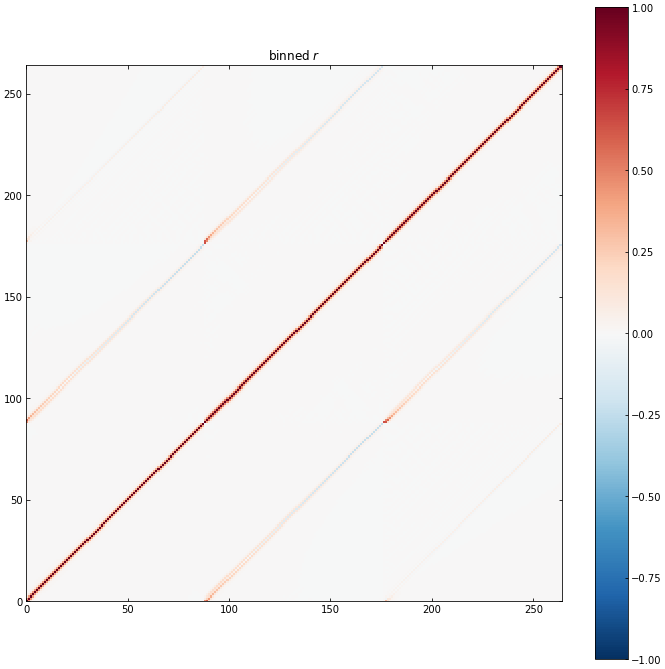

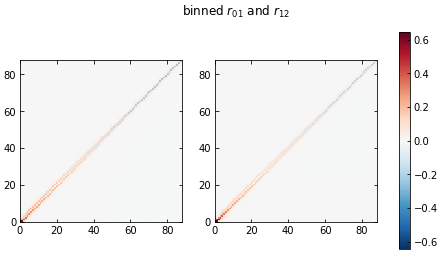

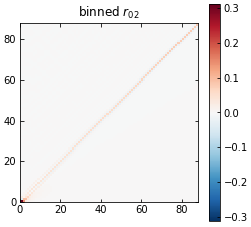

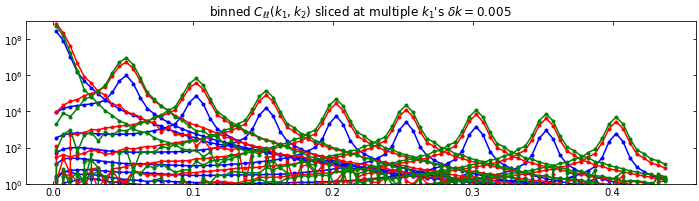

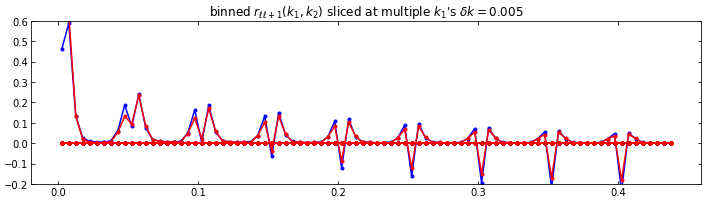

In [65]:
# visualize binned covariance Cb

pltmat(rb, scale='linear')
plt.title("binned $r$")
pltmat([rb[0, 1], rb[1, 2]], scale='linear')
plt.suptitle("binned $r_{01}$ and $r_{12}$")
pltmat(rb[0, 2], scale='linear')
plt.title("binned $r_{02}$")

idx = abs(bins - np.arange(0, 0.44, 0.05)[:, None]).argmin(axis=1)

plt.figure(figsize=(12, 3))
plt.plot(bincen, Cb[0, 0, idx].T, marker='.', c='b')
plt.plot(bincen, Cb[1, 1, idx].T, marker='.', c='r')
plt.plot(bincen, Cb[2, 2, idx].T, marker='.', c='g')
plt.title("binned $C_{\ell\ell}(k_1, k_2)$ sliced at multiple $k_1$'s $\delta k=0.005$")
plt.yscale('log')
plt.ylim(1, 1e9)
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(bincen, rb[0, 1, idx].T, marker='.', c='b')
plt.plot(bincen, rb[1, 2, idx].T, marker='.', c='r')
plt.title("binned $r_{\ell\ell+1}(k_1, k_2)$ sliced at multiple $k_1$'s $\delta k=0.005$")
plt.ylim(-.2, .6)
plt.show()

In [28]:
%%time

def get_Cb_data(z_bin, bootstrap=False):
    Pl_data = np.load(f"patchy/Pl_data_z{z_bin}.npy")
    shape = Pl_data.shape
    
    Pl_data = Pl_data.reshape(shape[0], -1)
    
    if bootstrap:
        choice = np.random.choice(shape[0], size=shape[0], replace=True)
        Pl_data = Pl_data[choice]
    
    Cb_data = np.cov(Pl_data, rowvar=False)
    Cb_data = Cb_data.reshape(shape[1:] * 2).swapaxes(1, 2)
    
    Cb_data = Cb_data[..., :len(bincen), :len(bincen)]
    
    return Cb_data

def bootstrap_Cb_data(z_bin, N=1000):
    Cb_data = get_Cb_data(z_bin)
    
    Cb_data_boot = np.zeros(Cb_data.shape + (N,))
    
    np.random.seed(0)
    for i in range(N):
        Cb_data_boot[..., i] = get_Cb_data(z_bin, bootstrap=True)
    Cb_data_err = Cb_data_boot.std(axis=-1)
    
    return Cb_data, Cb_data_err

Cb_data, Cb_data_err = bootstrap_Cb_data(z_bin)

rb_data = cov2cor(Cb_data)
rb_data_err = cov2cor(Cb_data_err, Cb)

# np.savez("fig/cov_data.npz", k=bincen, Cb=Cb_data, rb=rb_data, Pb0=Pb0)
# np.savez("fig/cov_err.npz", k=bincen, Cb=Cb_data_err, rb=rb_data_err, Pb0=Pb0)

CPU times: user 6.91 s, sys: 4.55 s, total: 11.5 s
Wall time: 6.19 s


In [29]:
Cb_diff = Cb_data - Cb

rb_data = cov2cor(Cb_data)
rb = cov2cor(Cb)

rb_diff = cov2cor(Cb_diff, Cb)

#np.savez("fig/cov_diff.npz", k=bincen, Cb=Cb_diff, rb=rb_diff, Pb0=Pb0)

In [30]:
def covconn(Cb_diff, Cb, rank):
    """Construct a smooth connected covariance"""
    if rank <= 0: raise ValueError
    
    rb_diff = cov2cor(Cb_diff, Cb)
    
    w, _, v_smooth = smooth_eig(rb_diff, rank)
    
    rb_conn = sum(val * vec[:, None] * vec for val, vec in zip(w, v_smooth.T))
    rb_conn = inflate(rb_conn, Cb.shape)
    
    Cb_conn = cor2cov(rb_conn, Cb)
    
    return Cb_conn

Cb_conn = covconn(Cb_diff, Cb, 4)
# Cb_conn = covconn(Cb_diff, Cb, 7)
rb_conn = cov2cor(Cb_conn, Cb)
Cb_disc = Cb_data - Cb_conn
rb_disc = cov2cor(Cb_disc, Cb)
Cb_disc_diff = Cb_disc - Cb
rb_disc_diff = cov2cor(Cb_disc_diff, Cb)

#np.savez("fig/cov_conn.npz", k=bincen, Cb=Cb_conn, rb=rb_conn, Pb0=Pb0)
#np.savez("fig/cov_disc.npz", k=bincen, Cb=Cb_disc, rb=rb_disc, Pb0=Pb0)
#np.savez("fig/cov_disc_diff.npz", k=bincen, Cb=Cb_disc_diff, rb=rb_disc_diff, Pb0=Pb0)

# np.save(f"Cb_conn_z{z_bin}.npy", Cb_conn)

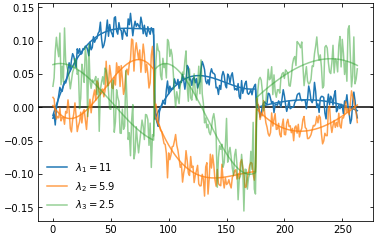

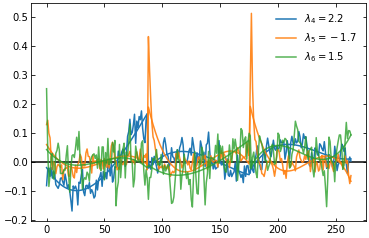

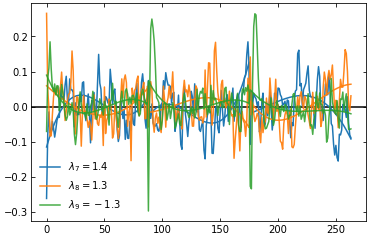

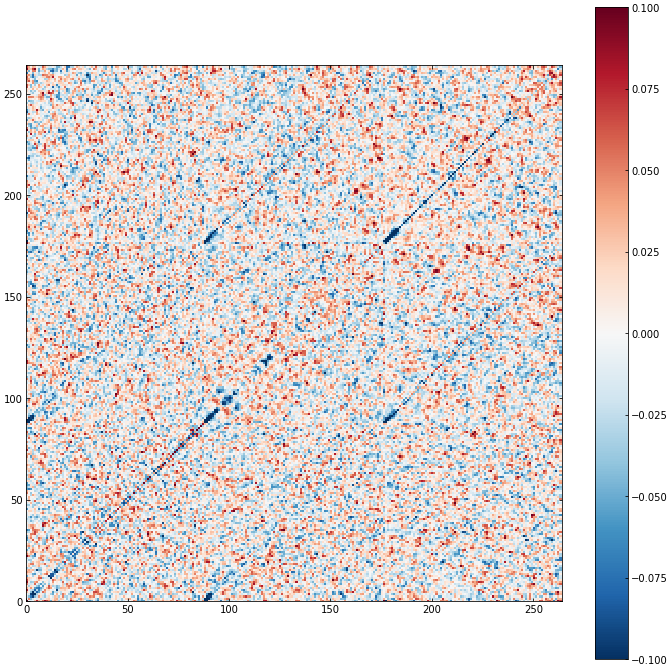

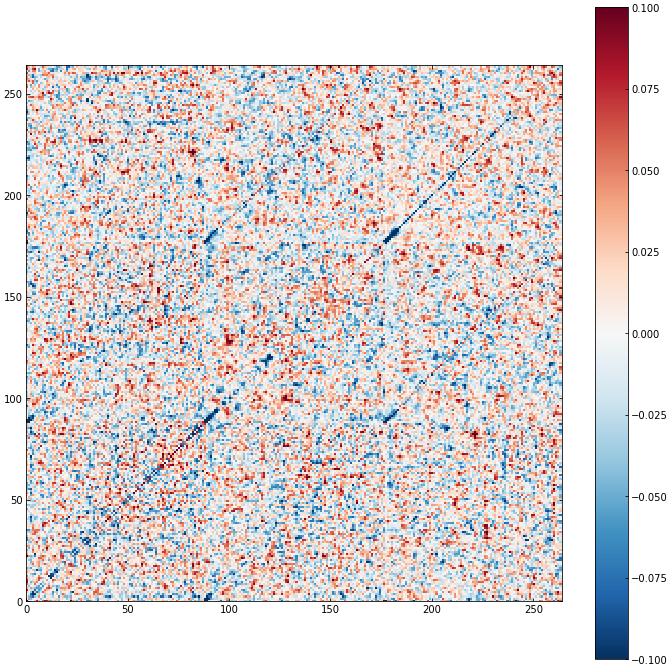

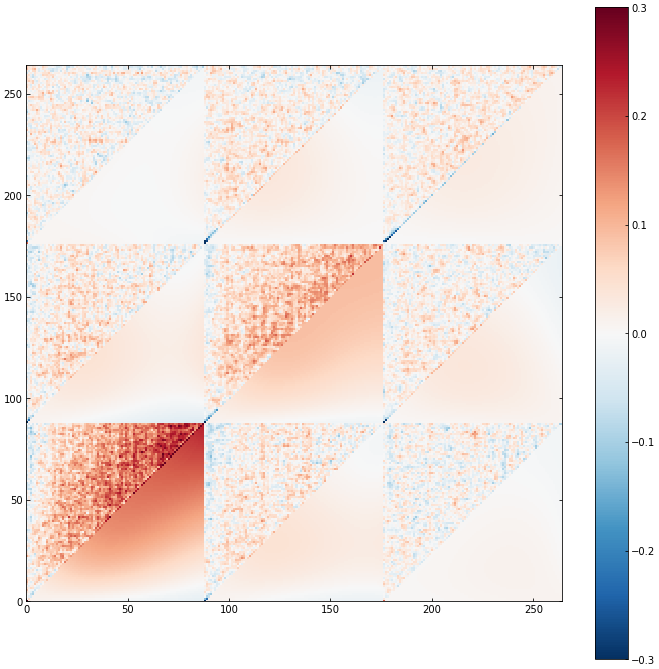

In [32]:
plteig(rb_diff, 3)
plt.show()
plteig(rb_diff, 6, rank0=3)
plt.show()
plteig(rb_diff, 9, rank0=6)
plt.show()
pltmat(rb_diff - lowrank(rb_diff, 4), scale='linear', vlim=0.1)
pltmat(rb_diff - rb_conn, scale='linear', vlim=0.1)
pltmat(np.tril(rb_diff) + np.triu(rb_conn, k=1), scale='linear', vlim=0.3)

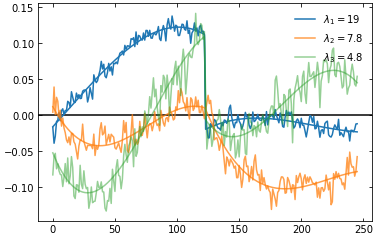

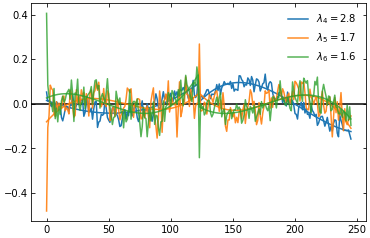

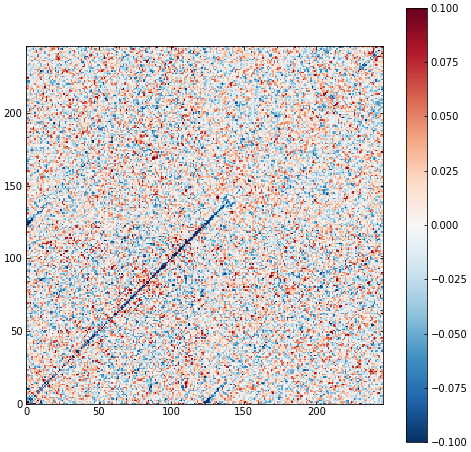

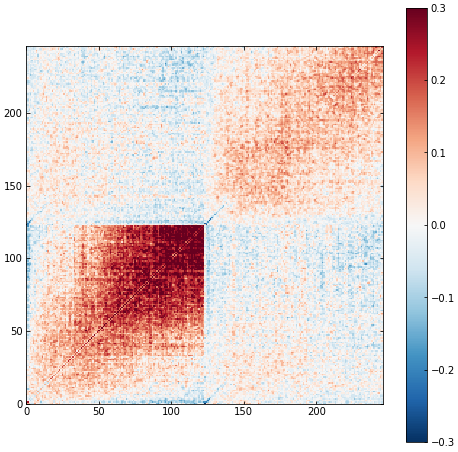

In [22]:
plteig(rb_diff[:2, :2], 3)
plt.show()
plteig(rb_diff[:2, :2], 6, rank0=3)
plt.show()
pltmat(rb_diff[:2, :2] - lowrank(rb_diff[:2, :2], 4), scale='linear', vlim=0.1)
pltmat(rb_diff[:2, :2], scale='linear', vlim=0.3)

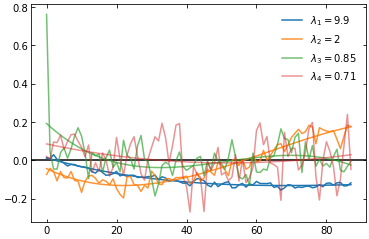

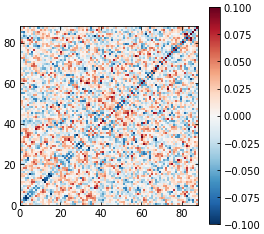

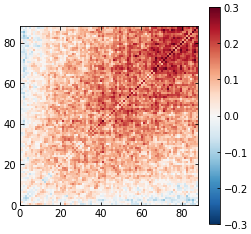

In [44]:
plteig(rb_diff[0, 0], 4)
pltmat(rb_diff[0, 0] - lowrank(rb_diff[0, 0], 3), scale='linear', vlim=0.1)
pltmat(rb_diff[0, 0], scale='linear', vlim=0.3)

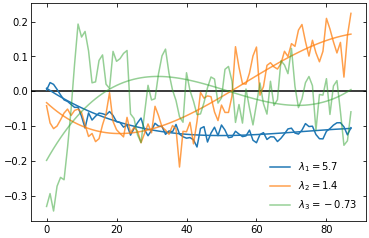

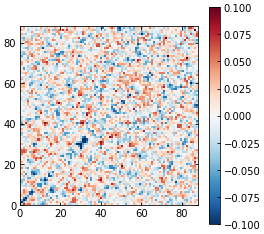

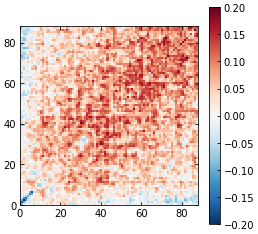

In [45]:
plteig(rb_diff[1, 1], 3)
pltmat(rb_diff[1, 1] - lowrank(rb_diff[1, 1], 3), scale='linear', vlim=0.1)
pltmat(rb_diff[1, 1], scale='linear', vlim=0.2)

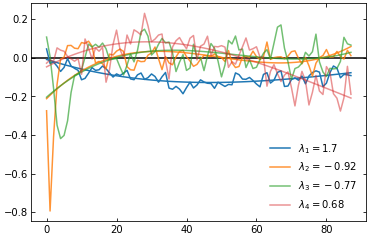

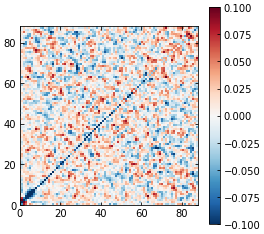

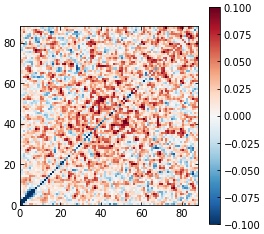

In [46]:
plteig(rb_diff[2, 2], 4)
pltmat(rb_diff[2, 2] - lowrank(rb_diff[2, 2], 2), scale='linear', vlim=0.1)
pltmat(rb_diff[2, 2], scale='linear', vlim=0.1)

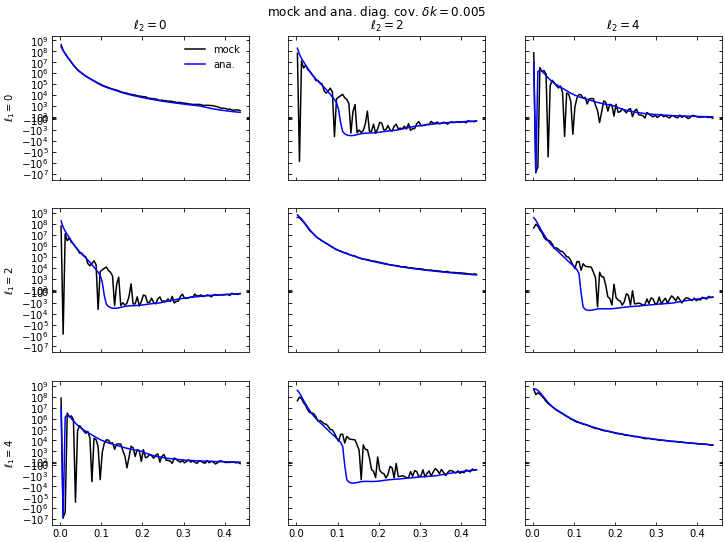

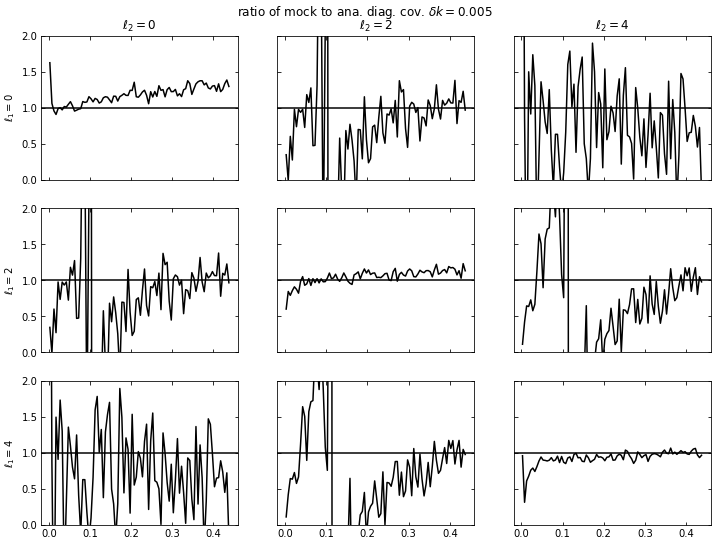

In [68]:
_, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 9))
for i in range(3):
    axes[i, 0].set_ylabel("$\ell_1 = {}$".format(2*i))
    axes[0, i].set_title("$\ell_2 = {}$".format(2*i))
    for j in range(3):
        axes[i, j].plot(bincen, Cb_data[i, j].diagonal(), 'k', label="mock")
        axes[i, j].plot(bincen, Cb[i, j].diagonal(), 'b', label="ana.")
axes[0, 0].legend()
plt.yscale('symlog', linthreshy=1e3)
plt.suptitle("mock and ana. diag. cov. $\delta k=0.005$", y=0.93)
plt.show()

_, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 9))
for i in range(3):
    axes[i, 0].set_ylabel("$\ell_1 = {}$".format(2*i))
    axes[0, i].set_title("$\ell_2 = {}$".format(2*i))
    for j in range(3):
        axes[i, j].plot(bincen, Cb_data[i, j].diagonal() / Cb[i, j].diagonal(), 'k')
        axes[i, j].axhline(1, c='k')
plt.ylim(0, 2)
plt.suptitle("ratio of mock to ana. diag. cov. $\delta k=0.005$", y=0.93)
plt.show()

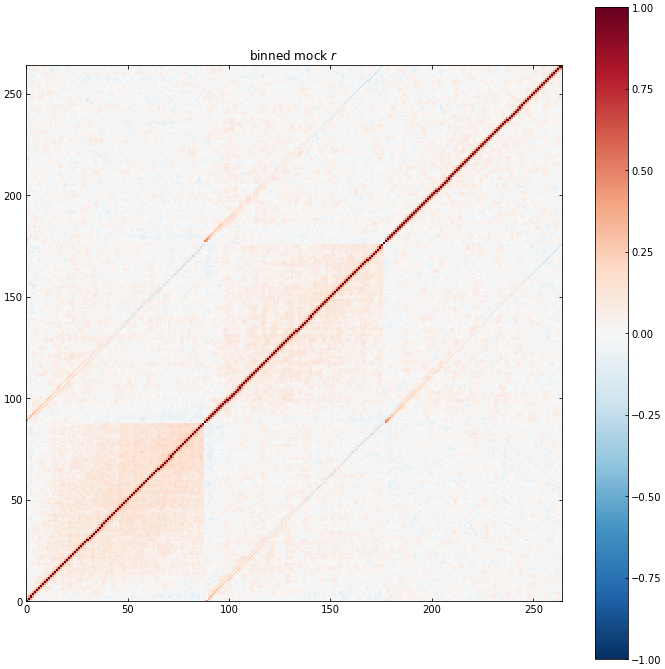

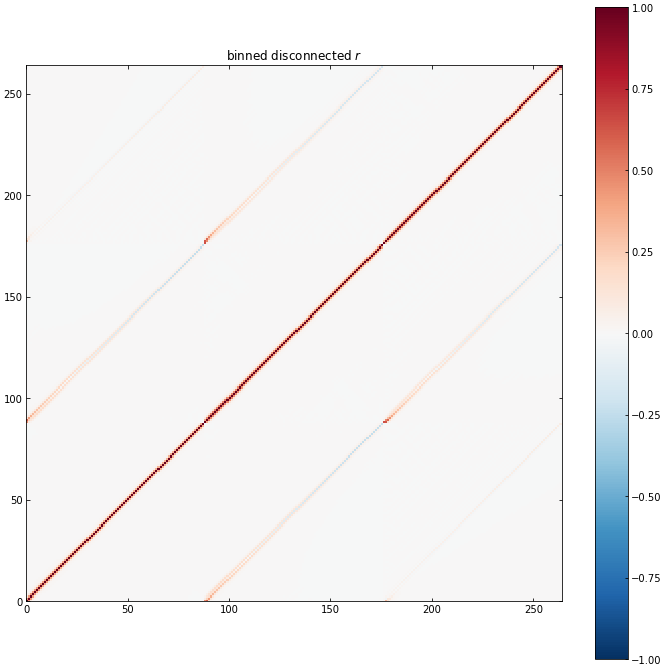

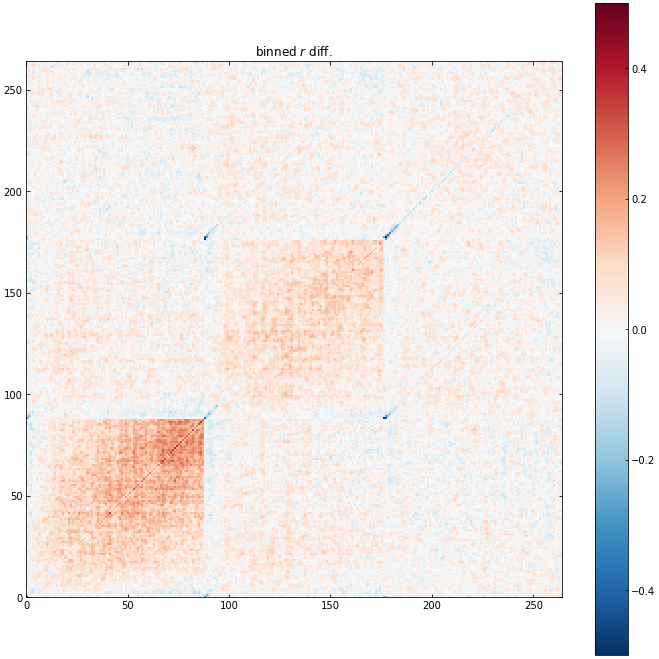

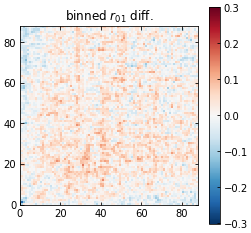

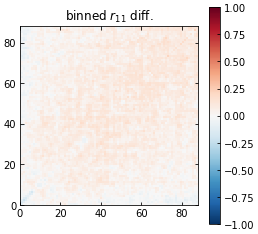

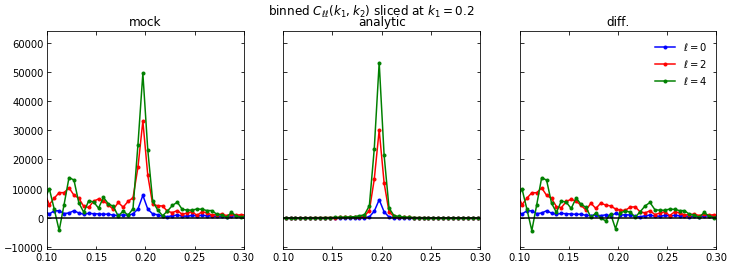

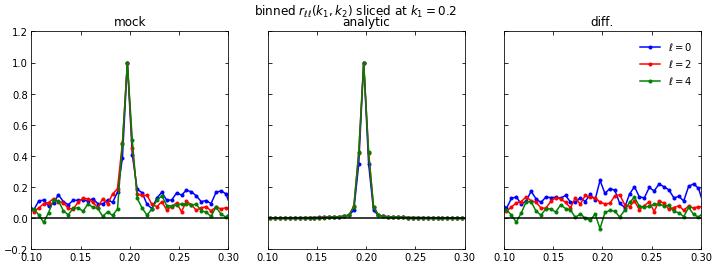

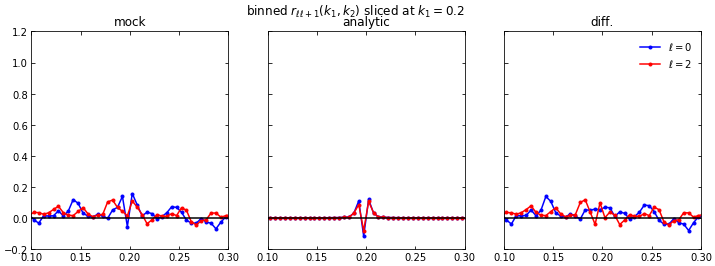

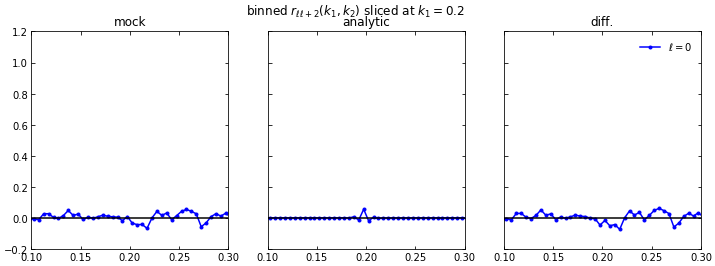

In [69]:
# visualize Cb difference

pltmat(rb_data, scale='linear')
plt.title("binned mock $r$")
pltmat(rb, scale='linear')
plt.title("binned disconnected $r$")
pltmat(rb_diff, scale='linear', vlim=0.5)
plt.title("binned $r$ diff.")
pltmat(rb_diff[0, 1], scale='linear')
plt.title("binned $r_{01}$ diff.")
pltmat(rb_diff[1, 1], scale='linear', vlim=1)
plt.title("binned $r_{11}$ diff.")
plt.show()

kmd = 0.2
idx = abs(bincen - kmd).argmin()
klo, khi = kmd-0.1, kmd+0.1

_, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
axes[0].plot(bincen, Cb_data[0, 0, idx], marker='.', c='b')
axes[0].plot(bincen, Cb_data[1, 1, idx], marker='.', c='r')
axes[0].plot(bincen, Cb_data[2, 2, idx], marker='.', c='g')
axes[0].axhline(c='k')
axes[0].set_title('mock')
axes[1].plot(bincen, Cb[0, 0, idx], marker='.', c='b')
axes[1].plot(bincen, Cb[1, 1, idx], marker='.', c='r')
axes[1].plot(bincen, Cb[2, 2, idx], marker='.', c='g')
axes[1].axhline(c='k')
axes[1].set_title('analytic')
axes[2].plot(bincen, Cb_diff[0, 0, idx], marker='.', c='b', label="$\ell=0$")
axes[2].plot(bincen, Cb_diff[1, 1, idx], marker='.', c='r', label="$\ell=2$")
axes[2].plot(bincen, Cb_diff[2, 2, idx], marker='.', c='g', label="$\ell=4$")
axes[2].axhline(c='k')
axes[2].set_title('diff.')
axes[2].legend()
plt.suptitle("binned $C_{{\ell\ell}}(k_1, k_2)$ sliced at $k_1={}$".format(kmd))
plt.xlim(klo, khi)
yhi = Cb[2, 2, idx, idx] * 1.2
ylo = - yhi / 6
plt.ylim(ylo, yhi)
plt.show()

_, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
axes[0].plot(bincen, rb_data[0, 0, idx], marker='.', c='b')
axes[0].plot(bincen, rb_data[1, 1, idx], marker='.', c='r')
axes[0].plot(bincen, rb_data[2, 2, idx], marker='.', c='g')
axes[0].axhline(c='k')
axes[0].set_title('mock')
axes[1].plot(bincen, rb[0, 0, idx], marker='.', c='b')
axes[1].plot(bincen, rb[1, 1, idx], marker='.', c='r')
axes[1].plot(bincen, rb[2, 2, idx], marker='.', c='g')
axes[1].axhline(c='k')
axes[1].set_title('analytic')
axes[2].plot(bincen, rb_diff[0, 0, idx], marker='.', c='b', label="$\ell=0$")
axes[2].plot(bincen, rb_diff[1, 1, idx], marker='.', c='r', label="$\ell=2$")
axes[2].plot(bincen, rb_diff[2, 2, idx], marker='.', c='g', label="$\ell=4$")
axes[2].axhline(c='k')
axes[2].set_title('diff.')
axes[2].legend()
plt.suptitle("binned $r_{{\ell\ell}}(k_1, k_2)$ sliced at $k_1={}$".format(kmd))
plt.xlim(klo, khi)
plt.ylim(-0.2, 1.2)
plt.show()

_, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
axes[0].plot(bincen, rb_data[0, 1, idx], marker='.', c='b')
axes[0].plot(bincen, rb_data[1, 2, idx], marker='.', c='r')
axes[0].axhline(c='k')
axes[0].set_title('mock')
axes[1].plot(bincen, rb[0, 1, idx], marker='.', c='b')
axes[1].plot(bincen, rb[1, 2, idx], marker='.', c='r')
axes[1].axhline(c='k')
axes[1].set_title('analytic')
axes[2].plot(bincen, rb_diff[0, 1, idx], marker='.', c='b', label="$\ell=0$")
axes[2].plot(bincen, rb_diff[1, 2, idx], marker='.', c='r', label="$\ell=2$")
axes[2].axhline(c='k')
axes[2].set_title('diff.')
axes[2].legend()
plt.suptitle("binned $r_{{\ell\ell+1}}(k_1, k_2)$ sliced at $k_1={}$".format(kmd))
plt.xlim(klo, khi)
plt.ylim(-0.2, 1.2)
plt.show()

_, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
axes[0].plot(bincen, rb_data[0, 2, idx], marker='.', c='b')
axes[0].axhline(c='k')
axes[0].set_title('mock')
axes[1].plot(bincen, rb[0, 2, idx], marker='.', c='b')
axes[1].axhline(c='k')
axes[1].set_title('analytic')
axes[2].plot(bincen, rb_diff[0, 2, idx], marker='.', c='b', label="$\ell=0$")
axes[2].axhline(c='k')
axes[2].set_title('diff.')
axes[2].legend()
plt.suptitle("binned $r_{{\ell\ell+2}}(k_1, k_2)$ sliced at $k_1={}$".format(kmd))
plt.xlim(klo, khi)
plt.ylim(-0.2, 1.2)
plt.show()

## Signal-to-noise

In [20]:
def get_Cllk_diag(k, bins, z_bin, l_max=4, l_P_max=4, simple_shot=False):
    """Return the diagonal C_ll(k, k') for all (l, l', k, k') ignoring window leakage
    (only nonzero when k == k')"""
    Plk = get_Plk(k, z_bin, add_shot=simple_shot)
    
    PP = Plk[:, None, :] * Plk[None, ...] * get_const(z_bin)['WW0']
    
    if not simple_shot:
        PPX = Plk * get_const(z_bin)['WS0']
        PP[0] += PPX
        PP[:, 0] += PPX
        
        PPS = get_const(z_bin)['SS0']
        PP[0, 0] += PPS
    
    PP, Vk = avg(k, PP, bins, w=4*np.pi*k**2, axis=-1)
    PP /= get_const(z_bin)['W0'] ** 2
    
    ell = get_ell(l_max)
    ell_P = get_ell(l_P_max)
    
    Cb = np.zeros((len(ell), len(ell), len(Vk), len(Vk)))
    diag = np.diag_indices(len(Vk))
    
    for i_l, l in enumerate(ell):
        for i_lp, lp in enumerate(ell):
            for i_l1, l1 in enumerate(ell_P):
                for i_l3, l3 in enumerate(ell_P):
                    w3j = sum((2*l2+1) * wigner_3j(l, l1, l2, 0, 0, 0)**2
                                       * wigner_3j(lp, l3, l2, 0, 0, 0)**2
                              for l2 in range(max(abs(l-l1), abs(lp-l3)), min(l+l1, lp+l3) + 1, 2))
                    Cb[i_l, i_lp] += np.diag(2*(2*l+1)*(2*lp+1) * float(w3j) * PP[i_l1, i_l3]
                                             * (2*np.pi)**3 / Vk)
    
    return Cb

Cb_diag = get_Cllk_diag(k, bins, z_bin)
# Cb_diag = get_Cllk_diag(k, bins, z_bin, simple_shot=True)
# np.savez("fig/cov_diag.npz", k=bincen, Cb=Cb_diag)
# np.savez("fig/cov_diag_wrong.npz", k=bincen, Cb=Cb_diag)

# k_ratio = np.exp(np.mean(np.diff(np.log(k))))
# C_diag = get_Cllk_diag(k, np.append(k * k_ratio**-0.5, k[-1] * k_ratio**0.5), z_bin)

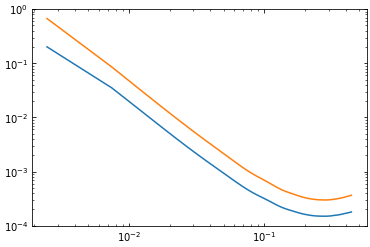

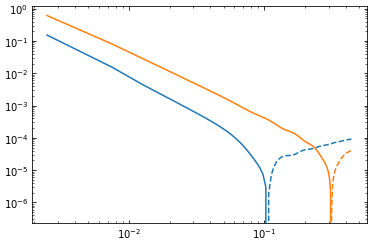

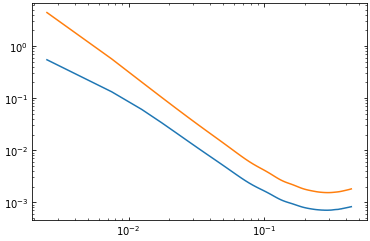

In [21]:
plt.loglog(bincen, Cb[0, 0].diagonal() / Pb0**2)
plt.loglog(bincen, Cb_diag[0, 0].diagonal() / Pb0**2)
plt.show()
l1, = plt.loglog(bincen, Cb[0, 1].diagonal() / Pb0**2)
l2, = plt.loglog(bincen, Cb_diag[0, 1].diagonal() / Pb0**2)
plt.loglog(bincen, -Cb[0, 1].diagonal() / Pb0**2, c=l1.get_color(), ls='--')
plt.loglog(bincen, -Cb_diag[0, 1].diagonal() / Pb0**2, c=l2.get_color(), ls='--')
plt.show()
plt.loglog(bincen, Cb[1, 1].diagonal() / Pb0**2)
plt.loglog(bincen, Cb_diag[1, 1].diagonal() / Pb0**2)

/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Ambiguity in deflation
  This is separate from the ipykernel package so we can avoid doing imports until


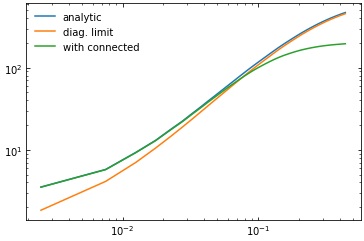

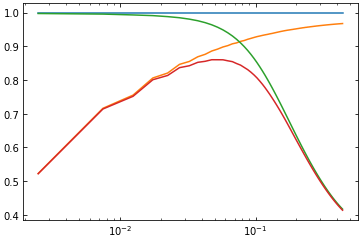

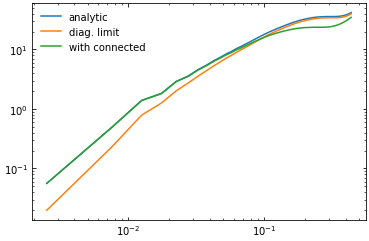

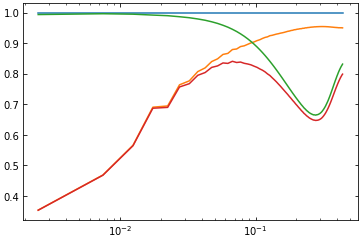

In [47]:
def get_Pb_conv(z_bin, return_data=True):
    if return_data:
        return np.load(f"patchy/Pl_data_z{z_bin}.npy").mean(axis=0)
    
    Pl_file = f"patchy/Pl_model_z{z_bin}_conv.dat"
    Pl_data = np.loadtxt(Pl_file, unpack=True)
    _k = Pl_data[0]
    _P = Pl_data[1:]
    
    Pb, _ = avg(_k, _P, bins, w=_k**2, axis=1)
    
    return Pb

def get_SN(Pb, Cb):
    """Return signal-to-noise as function of k_max."""
    SN2 = np.zeros(Pb.shape[-1])
    
    for i in range(len(SN2)):
        Cb_inv = np.linalg.inv(deflate(Cb[..., :i+1, :i+1]))
        SN2[i] = Pb[:, :i+1].ravel() @ Cb_inv @ Pb[:, :i+1].ravel()
    
    return np.sqrt(SN2)

Pb = get_Pb_conv(z_bin)

SN = get_SN(Pb[0:2], Cb[0:2, 0:2])
SN_diag = get_SN(Pb[0:2], Cb_diag[0:2, 0:2])
SN_data = get_SN(Pb[0:2], (Cb+Cb_conn)[0:2, 0:2])
SN_diag_conn = get_SN(Pb[0:2], (Cb_diag+Cb_conn)[0:2, 0:2])

plt.loglog(bincen, SN, label="analytic")
plt.loglog(bincen, SN_diag, label="diag. limit")
plt.loglog(bincen, SN_data, label="with connected")
plt.legend()
plt.savefig("P0_SNR.png")
plt.show()
plt.semilogx(bincen, SN / SN)
plt.semilogx(bincen, SN_diag / SN)
plt.semilogx(bincen, SN_data / SN)
plt.semilogx(bincen, SN_diag_conn / SN)
plt.savefig("P0_SNR_ratio.png")
plt.show()

SN = get_SN(Pb[1:2], Cb[1:2, 1:2])
SN_diag = get_SN(Pb[1:2], Cb_diag[1:2, 1:2])
SN_data = get_SN(Pb[1:2], (Cb+Cb_conn)[1:2, 1:2])
SN_diag_conn = get_SN(Pb[1:2], (Cb_diag+Cb_conn)[1:2, 1:2])

plt.loglog(bincen, SN, label="analytic")
plt.loglog(bincen, SN_diag, label="diag. limit")
plt.loglog(bincen, SN_data, label="with connected")
plt.legend()
plt.savefig("P2_SNR.png")
plt.show()
plt.semilogx(bincen, SN / SN)
plt.semilogx(bincen, SN_diag / SN)
plt.semilogx(bincen, SN_data / SN)
plt.semilogx(bincen, SN_diag_conn / SN)
plt.savefig("P2_SNR_ratio.png")
plt.show()